In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/COMP 4471/assignment3')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Setup

## Libraries and helper functions

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import timeit


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]//3)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        new_img = np.transpose(img.reshape([3, sqrtimg,sqrtimg]), (1,2,0))
        plt.imshow(new_img)
    return

def save_images(images, filename):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]//3)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        new_img = np.transpose(img.reshape([3, sqrtimg,sqrtimg]), (1,2,0))
        plt.imshow(new_img)
    plt.savefig(filename)
    return 


## Dataset

In [0]:
batch_size = 128
image_size = 64
num_channel = 3
NUM_TRAIN = 49000
NUM_VAL = 1000
batch_shape = (batch_size, num_channel, image_size, image_size)


In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

cifar10_train = dset.CIFAR10('./extra_credits/datasets', train=True, download=True,
                              transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor()
                           ]))
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('./extra_credits/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./extra_credits/datasets', train=False, download=True,
                          transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


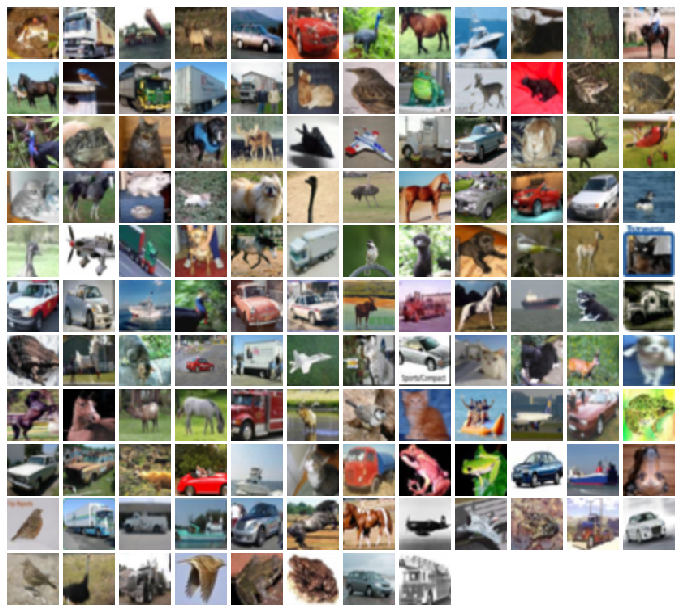

In [5]:
imgs = loader_train.__iter__().next()[0].view(batch_size, num_channel*image_size*image_size).numpy().squeeze()
show_images(imgs)

## Random Noise

In [0]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return 2*(torch.rand((batch_size,dim)) - 0.5)


## Flatten

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
      m.weight.data.normal_(1.0, 0.02)
      m.bias.data.fill_(0)

## CPU/GPU

In [0]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


# Build GAN structure for CIFAR-10

## Discriminator

In [0]:
class Discriminator_CNN(nn.Module):
    def __init__(self):
      super(Discriminator_CNN, self).__init__()
      self.model = nn.Sequential(
          Unflatten(batch_shape),
          nn.Conv2d(num_channel, 64, 4, stride=2, padding=1, bias=False), # Output shape: 1 + (64-4+2*1)//2 = 32x32
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False), #  16x16
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2,inplace=True),

          nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False), # size = 8x8
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2,inplace=True),

          nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False), # size = 4x4
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2,inplace=True),

          nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False), # size = 1 + (4-4+2*0) = 1x1
          nn.Sigmoid()
      )

    def forward(self, x):
      return self.model(x).view(-1,1).squeeze(1)

## Generator

In [0]:
class Generator_CNN(nn.Module):
    def __init__(self, num_feat):
      super(Generator_CNN, self).__init__()
      # for padding = 0, H_new = H_old + kernel_size - 1
      # for padding = 1, H_new = H_old*stride
      self.model = nn.Sequential(
        Unflatten(batch_size, num_feat, 1, 1),
        nn.ConvTranspose2d(num_feat, 512, 4, stride=1, padding=0, bias=False), # output size = 1 + 4 - 1 = 4
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False), # 8x8
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False), # 16x16
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False), # 32x32
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False), # 64x64
        nn.Tanh()
      )

    def forward(self, x):
      return self.model(x)

## GAN Loss

In [0]:
bce_loss = nn.BCELoss()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    N = logits_fake.shape
    true_labels = Variable(torch.ones(N)).type(dtype)
    fake_labels = Variable(torch.zeros(N)).type(dtype)
    
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, fake_labels)
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    N = logits_fake.shape
    true_labels = Variable(torch.ones(N)).type(dtype)
    loss = bce_loss(logits_fake, true_labels)
    return loss

## Optimizer

In [0]:
def get_optimizer(model):

    optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5,0.999))
    return optimizer

## Trainer

In [0]:
class Trainer():
  def __init__(self, dataloader, D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_feat=100, batch_size=batch_size):
    self.dataloader = dataloader 
    self.D = D
    self.G = G
    self.D_solver = D_solver
    self.G_solver = G_solver
    self.discriminator_loss = discriminator_loss
    self.generator_loss = generator_loss
    self.num_feat = num_feat
    self.batch_size = batch_size

  
  def train(self, num_epochs, show_every=250, save_result=False):
    iter_count = 0
    if save_result:
      if not os.path.exists('extra_credits/GAN-CIFAR/'):
        os.makedirs('extra_credits/GAN-CIFAR/')
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(self.dataloader, 0):
            if len(x) != self.batch_size:
              continue
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            self.D.zero_grad()
          
            real_data = Variable(x).type(dtype)
            logits_real = D(real_data)

            g_fake_seed = Variable(sample_noise(self.batch_size, self.num_feat)).type(dtype)
            fake_data = G(g_fake_seed)
            logits_fake = D(fake_data.detach())

            errD = self.discriminator_loss(logits_real, logits_fake)
            errD.backward()
            self.D_solver.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            self.G.zero_grad()
            logits_fake = self.D(fake_data)
            errG = self.generator_loss(logits_fake)
            errG.backward()
            self.G_solver.step()
            
            
            #save the output
            if (iter_count % show_every == 0):

              print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,errD,errG))
              output_img = fake_data #/2 + 0.5
              imgs_numpy = output_img.data.cpu().numpy()
              if save_result:
                filename = "iteration_" + str(iter_count)
                save_images(imgs_numpy[0:16], 'extra_credits/GAN-CIFAR/{}.png'.format(filename, bbox_inches='tight'))
              else:
                show_images(imgs_numpy[0:16])
              plt.show()
              print()
            iter_count += 1

  def print_info(self):
    print("Batch size: {}".format(self.batch_size))
    print("Feature numbers: {}".format(self.num_feat))
    print("Networks:")
    print(self.G)
    print(self.D)




# Train for GAN

## Information

In [17]:
num_feat = 100
D = Discriminator_CNN().type(dtype)
D.apply(initialize_weights)

G = Generator_CNN(num_feat).type(dtype)
G.apply(initialize_weights)

# setup optimizer
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

my_trainer = Trainer(loader_train, D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_feat, batch_size)

my_trainer.print_info()


Batch size: 128
Feature numbers: 100
Networks:
Generator_CNN(
  (model): Sequential(
    (0): Unflatten()
    (1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=

## Training

In [18]:
my_trainer.train(num_epochs=10, save_result=True)

Output hidden; open in https://colab.research.google.com to view.